# Classification of the Data

## Data Loading and preparation

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


n_classes = 10
# data
X_features = [
    "mood","circumplex.arousal","circumplex.valence","activity","screen",
    "call","sms", "day_sin", "day_cos", "day_year_sin", "day_year_cos", "appCat_total", "appCat.builtin", "appCat.communication",
    "appCat.entertainment", "appCat.finance", "appCat.game", "appCat.office",
    "appCat.social", "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"
]
Y_features = [
    "mood_of_next_day"
]
df_data = pd.read_csv("./data/imputed_data.csv")
df_data["datetime"] = pd.to_datetime(df_data["datetime"])

# Reduce mood score to 5 classes
#df_data["mood"] = df_data["mood"] / 2
#df_data[Y_features[0]] = df_data[Y_features[0]] / 2


df_test = pd.DataFrame()
df_train = pd.DataFrame()
for subject_id in df_data["id"].unique():
    df_subject = df_data[df_data["id"]==subject_id]

    df_subject = df_subject.sort_values(by="datetime")
    split_index = int(0.8 * len(df_subject))
    #subject_test_indices = TimeSeriesSplit(n_splits=2, test_size=len(df_subject)*0.2).split(df_subject)
    df_train = pd.concat([df_train, df_subject.iloc[:split_index]])
    df_test = pd.concat([df_test, df_subject.iloc[split_index:]])

#df_train = pd.read_csv("./data/train_data_imputed.csv", index_col=0)
#df_train["time"] = pd.to_datetime(df_train["time"])
#df_test = pd.read_csv("./data/test_data_imputed.csv", index_col=0)
#df_test["time"] = pd.to_datetime(df_test["time"])


for column in ["screen", "call","sms",*X_features[11:]]:
    df_train[column] = (df_train[column] - df_train[column].mean())/df_train[column].std()
    df_test[column] = (df_test[column] - df_test[column].mean())/df_test[column].std()

min_c, max_c = -2, 2
for column in ["circumplex.arousal", "circumplex.valence"]:
    df_train[column] = (df_train[column] - min_c) / (max_c - min_c)
    df_test[column] = (df_test[column] - min_c) / (max_c - min_c)

for column in ["mood", "mood_of_next_day"]:
    df_train[column] = df_train[column].round(0)
    df_test[column] = df_test[column].round(0)

# add week and day sin cos features
for df_tmp in [df_train, df_val, df_test]:
    df_tmp["day_sin"] = df_tmp["day_of_week"].apply(lambda x: np.sin((x-1)*(2*np.pi/6)))
    df_tmp["day_cos"] = df_tmp["day_of_week"].apply(lambda x: np.cos((x-1)*(2*np.pi/6)))
    df_tmp["day_year_sin"] = df_tmp["datetime"].dt.isocalendar().week.apply(lambda x: np.sin((x-1)*(2*np.pi/52)))
    df_tmp["day_year_cos"] = df_tmp["datetime"].dt.isocalendar().week.apply(lambda x: np.cos((x-1)*(2*np.pi/52)))

#df_test["day_sin"] = df_test["day_of_week"].apply(lambda x: np.sin((x-1)*(2*np.pi/6)))
#df_test["day_cos"] = df_test["day_of_week"].apply(lambda x: np.cos((x-1)*(2*np.pi/6)))

#df_train["day_year_sin"] = df_train["datetime"].dt.isocalendar().week.apply(lambda x: np.sin((x-1)*(2*np.pi/52)))
#df_train["day_year_cos"] = df_train["datetime"].dt.isocalendar().week.apply(lambda x: np.cos((x-1)*(2*np.pi/52)))
#df_test["day_year_sin"] = df_test["datetime"].dt.isocalendar().week.apply(lambda x: np.sin((x-1)*(2*np.pi/52)))
#df_test["day_year_cos"] = df_test["datetime"].dt.isocalendar().week.apply(lambda x: np.cos((x-1)*(2*np.pi/52)))

x = np.arange(2, 8, 0.1)
x = x-1
y = np.sin((x-1)*(2*np.pi/6))
y_cos = np.cos((x-1)*(2*np.pi/6))
# Plotting Sine Graph
plt.plot(x, y, color='green')
plt.plot(x, y_cos, color="blue")
plt.scatter(np.array(df_train["day_of_week"]), np.array(df_train["day_sin"]))
plt.scatter(np.array(df_train["day_of_week"]), np.array(df_train["day_cos"]))

plt.title("Encoded day of the week values (sin+cos encoding)")
plt.show()

x = np.arange(1, 52, 0.5)
y = np.sin((x-1)*(2*np.pi/52))
y_cos = np.cos((x-1)*(2*np.pi/52))

plt.plot(x, y, color='green')
plt.plot(x, y_cos, color="blue")
plt.scatter(np.array(df_train["datetime"].dt.isocalendar().week), np.array(df_train["day_year_sin"]))
plt.scatter(np.array(df_train["datetime"].dt.isocalendar().week), np.array(df_train["day_year_cos"]))

plt.scatter(np.array(df_test["datetime"].dt.isocalendar().week), np.array(df_test["day_year_sin"]), color="brown")
plt.scatter(np.array(df_test["datetime"].dt.isocalendar().week), np.array(df_test["day_year_cos"]), color="purple")
plt.title("Encoded week of the year values")
plt.show()


NameError: name 'df_val' is not defined

### Windowing

In [8]:
from windowing import WindowGenerator

w_mood_classification = WindowGenerator(
  input_width=7,
  label_width=0, 
  label_column=Y_features[0], 
  feature_columns=X_features,
  df_train=df_train,
  df_val=df_val,
  df_test=df_test,
  num_classes=10,
  datetime_label="datetime",
)

X_train_classification, Y_train_classification = w_mood_classification.train
X_validation_classification, Y_validation_classification = w_mood_classification.val
X_test_classification, Y_test_classification = w_mood_classification.test

print(X_train_classification.shape, Y_train_classification.shape)
print(X_validation_classification.shape, Y_validation_classification.shape)
print(X_test_classification.shape, X_test_classification.shape)


w_mood_regression = WindowGenerator(
  input_width=7,
  label_width=0, 
  label_column=Y_features[0], 
  feature_columns=X_features,
  df_train=df_train,
  df_val=df_val,
  df_test=df_test,
  num_classes=10,
  datetime_label="datetime",
  regression=True
)

X_train_regression, Y_train_regression = w_mood_regression.train
X_validation_regression, Y_validation_regression = w_mood_regression.val
X_test_regression, Y_test_regression = w_mood_regression.test

print(X_train_regression.shape, Y_train_regression.shape)
print(X_validation_regression.shape, Y_validation_regression.shape)
print(X_test_regression.shape, Y_test_regression.shape)

Original sample: 980, windowed data points: 765


TypeError: 'NoneType' object is not subscriptable

## Optimization Setup

First we setup the code for optimization

In [3]:
# shared variables in both optimization parts
repetitions = 2

In [5]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential


def get_classification_model(encoding_layers, classification_layers, lstm_units, dropout):
    encoding_layers_list = []
    for i in range(encoding_layers):
        encoding_layers_list += [Dense(2**(5+i), activation="relu"), Dropout(dropout)]

    classification_layers_list = []
    for i in range(classification_layers):
        classification_layers_list += [Dropout(dropout), Dense(2**(5+i), activation="relu")]
    classification_layers_list = classification_layers_list[::-1]
    classification_layers_list = classification_layers_list[:-1]
    LSTM_model = Sequential([
        *encoding_layers_list,
        LSTM(lstm_units),
        *classification_layers_list,
        Dense(n_classes, activation="softmax")
    ])
    return LSTM_model

# function that should be maximized by the bayesian optimization
def train_wrapper_classification(bs: float, lr: float, lstm_units: float, encoding_layers: float, classification_layers: float, dropout: float):
    batch_size = int(bs)
    lstm_units = int(lstm_units)
    encoding_layers = int(encoding_layers)
    classification_layers = int(classification_layers)

    # return negative value to turn a minimization to a maximization problem
    results = [
        -train_network_classification(batch_size, lr, lstm_units, encoding_layers, classification_layers, dropout) for _ in range(repetitions)
    ]
    # average scores
    return sum(results)/len(results)


def train_network_classification(bs: int, lr: float, lstm_units: int, encoding_layers: int, classification_layers: int, dropout: float) -> float:
    
    #print(LSTM_model.summary())
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=150,
        mode='min'
    )
    LSTM_model = get_classification_model(encoding_layers, classification_layers, lstm_units, dropout)
    LSTM_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["accuracy", "f1_score"]
    )

    history = LSTM_model.fit(x=X_train_classification, y=Y_train_classification, epochs=1000, batch_size=bs,
                        validation_data=(X_validation_classification, Y_validation_classification),
                        callbacks=[early_stopping],
                        verbose=0)
    # return the lowest validation loss seen
    return min(history.history["val_loss"])
    

TypeError: cannot unpack non-iterable ellipsis object

Now the same for the regression model

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential


def get_regression_model(encoding_layers, regression_layers, lstm_units, dropout):
    encoding_layers_list = []
    for i in range(encoding_layers):
        encoding_layers_list += [Dense(2**(5+i), activation="relu"), Dropout(dropout)]

    regression_layers_list = []
    for i in range(regression_layers):
        regression_layers_list += [Dropout(dropout), Dense(2**(5+i), activation="relu")]
    regression_layers_list = regression_layers_list[::-1]
    regression_layers_list = regression_layers_list[:-1]
    LSTM_model = Sequential([
        *encoding_layers_list,
        LSTM(lstm_units),
        *regression_layers_list,
        Dense(1)
    ])
    return LSTM_model

# function that should be maximized by the bayesian optimization
def train_wrapper_regression(bs: float, lr: float, lstm_units: float, encoding_layers: float, classification_layers: float, dropout: float):
    batch_size = int(bs)
    lstm_units = int(lstm_units)
    encoding_layers = int(encoding_layers)
    classification_layers = int(classification_layers)

    # return negative value to turn a minimization to a maximization problem
    results = [
        -train_network_regression(batch_size, lr, lstm_units, encoding_layers, classification_layers, dropout) for _ in range(repetitions)
    ]
    # average scores
    return sum(results)/len(results)


def train_network_regression(bs: int, lr: float, lstm_units: int, encoding_layers: int, regression_layers: int, dropout: float) -> float:
    #print(LSTM_model.summary())
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=150,
        mode='min'
    )
    LSTM_model = get_regression_model(encoding_layers, regression_layers, lstm_units, dropout)
    LSTM_model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["mse", "mae"]
    )

    history = LSTM_model.fit(x=X_train_regression, y=Y_train_regression, epochs=1000, batch_size=bs,
                        validation_data=(X_validation_regression, Y_validation_regression),
                        callbacks=[early_stopping],
                        verbose=0)
    # return the lowest validation loss seen
    return min(history.history["val_loss"])
    

## Classification Model

In [29]:
def compile_and_fit(model, window, patience=30, bs=10, lr=0.01, max_epochs=30, regression=False):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  if not regression:
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["accuracy", "f1_score"])
  else:
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["mse", "mae"])
  X_train, Y_train = window.train
  X_test, Y_test = window.test
  history = model.fit(x=X_train, y=Y_train, epochs=max_epochs, batch_size=bs,
                      validation_data=(X_test, Y_test),
                      callbacks=[early_stopping])
  return history

In [ ]:
# pip install bayesian-optimization
from bayes_opt import BayesianOptimization


# Bounded region of parameter space
pbounds = {
    'bs': (1, 1000),
    'lr': (0, 0.01),
    "lstm_units": (32, 512),
    "encoding_layers": (1, 4),
    "classification_layers": (1, 4),
    "dropout": (0, 0.6)
}


optimizer = BayesianOptimization(
    f=train_wrapper_classification,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=50,
)

print(optimizer.max)

In [30]:
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

n_classes = 10
MAX_EPOCHS = 3000
lr = 0.0002
bs = 1000


x = w_mood.train[0]
LSTM_model = Sequential([
    Dense(16, activation="relu", input_shape=(x.shape[1], x.shape[2])),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation="tanh"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="tanh"),
    LSTM(128, dropout=0.2),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(n_classes, activation="softmax")
])
#LSTM_model.summary()

compile_and_fit(LSTM_model, w_mood, patience=500, bs=bs, lr=lr, max_epochs=MAX_EPOCHS)


Original sample: 980, windowed data points: 765


/home/m/Desktop/Projects/DMT/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Original sample: 980, windowed data points: 765
Original sample: 261, windowed data points: 87
Epoch 1/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1529 - f1_score: 0.0631 - loss: 2.4883 - val_accuracy: 0.3448 - val_f1_score: 0.0885 - val_loss: 2.2494
Epoch 2/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1529 - f1_score: 0.0588 - loss: 2.4882 - val_accuracy: 0.3333 - val_f1_score: 0.0839 - val_loss: 2.2447
Epoch 3/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1359 - f1_score: 0.0581 - loss: 2.4818 - val_accuracy: 0.3333 - val_f1_score: 0.0821 - val_loss: 2.2401
Epoch 4/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1595 - f1_score: 0.0678 - loss: 2.3906 - val_accuracy: 0.3218 - val_f1_score: 0.0780 - val_loss: 2.2346
Epoch 5/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1791 - f1_score: 0.0710 - loss: 2.3662 - val_accuracy: 0.3563 - val_f1_score: 0.0907 - val_loss: 2.2287
Epoch 6/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accura

KeyboardInterrupt: 

In [18]:
# evaluate final model
x, y = w_mood.train
x_test, y_test = w_mood.test
y_hat = LSTM_model.predict(x)
y_hat_index = np.argmax(y_hat, axis=1)
y_actual_train = np.argmax(y, axis=1)
print(sum(y_hat_index==y_actual_train)/y_actual_train.shape[0])

y_hat = LSTM_model.predict(x_test)
y_hat_index = np.argmax(y_hat, axis=1)
y_actual = np.argmax(y_test, axis=1)
print(sum(y_hat_index==y_actual)/y_actual.shape[0])

Original sample: 980, windowed data points: 765
Original sample: 261, windowed data points: 87
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
0.7398692810457517
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.6551724137931034


1


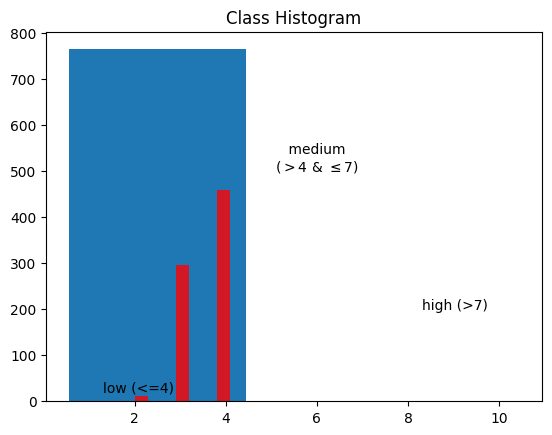

In [31]:
# plotting mood categories
y_fixed_actual = y_actual_train + 1
y_number = sum(((y_fixed_actual>4)) & (y_fixed_actual<=7))
print(y_number)

barlist = plt.bar([2, 6, 9], [sum(y_fixed_actual<=4), y_number, sum(y_fixed_actual>7)], width=2.9)
barlist[0].set_width(3.9)
plt.hist(y_fixed_actual, color="red", alpha=0.8)
plt.text(1.3, 20, "low (<=4)")
plt.text(5, 500, "    medium\n ($>4$ & $\leq7$)")
plt.text(8.3, 200, "high (>7)")
plt.title("Class Histogram")
plt.savefig("images/rnn_dataset")



## Regression Model

In [42]:
w_mood_regression = WindowGenerator(7, 0, 
  label_column=Y_features[0], 
  feature_columns=X_features,
  df_train=df_train,
  df_val=None,
  df_test=df_test,
  num_classes=10,
  datetime_label="datetime",
  regression=True
)
X_train_windowed, Y_train = w_mood_regression.train
print(f"Training data shape: {X_train_windowed.shape}, y shape: {Y_train.shape}")
print(w_mood_regression.feature_columns)
print(X_train_windowed[0][0])
print(Y_train[0])

Original sample: 980, windowed data points: 765
Training data shape: (765, 7, 23), y shape: (765,)
['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms', 'day_sin', 'day_cos', 'day_year_sin', 'day_year_cos', 'appCat_total', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']
[ 6.          0.55        0.55        0.1340501   2.52503301  1.08778607
 -0.47901595 -0.8660254  -0.5         0.97094182  0.23931566  1.81896206
  0.54173338  1.48082884  0.08555424  0.66569183 -0.16014185  0.06350993
  1.74995446  2.27722089 -0.20724835  3.55248874 -0.20165322]
6.0


In [49]:
n_classes = 10
MAX_EPOCHS = 3000
lr = 0.0002
bs = 1000


x = w_mood_regression.train[0]
LSTM_model_regression = Sequential([
    Dense(32, activation="relu", input_shape=(x.shape[1], x.shape[2])),
    Dropout(0.2),
    Dense(64, activation="relu"),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1)
])
#LSTM_model_regression.summary()

compile_and_fit(LSTM_model_regression, w_mood_regression, patience=500, bs=bs, lr=lr, max_epochs=MAX_EPOCHS, regression=True)

Original sample: 980, windowed data points: 765


/home/m/Desktop/Projects/DMT/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Original sample: 980, windowed data points: 765
Original sample: 261, windowed data points: 87
Epoch 1/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 53.4566 - mae: 7.2616 - mse: 53.4566 - val_loss: 53.9217 - val_mae: 7.3000 - val_mse: 53.9217
Epoch 2/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 51.9665 - mae: 7.1590 - mse: 51.9665 - val_loss: 52.3876 - val_mae: 7.1946 - val_mse: 52.3876
Epoch 3/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 50.4791 - mae: 7.0543 - mse: 50.4791 - val_loss: 50.8861 - val_mae: 7.0899 - val_mse: 50.8861
Epoch 4/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 48.8884 - mae: 6.9421 - mse: 48.8884 - val_loss: 49.4395 - val_mae: 6.9876 - val_mse: 49.4395
Epoch 5/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 47.6241 - mae: 6.8506 - mse: 47.6241 - val_loss: 48.0436 - val_mae: 6.8874 - val_mse: 48.0436
Epoch 6/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 46.2795 - mae: 6.7519 - mse: 46.2795 - val_loss: 46.7193 - val_mae: 6.7910 - val_ms

In [31]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential


X_train, Y_train = w_mood.train
X_test, Y_test = w_mood.test
n_classes = 10
repetitions = 2


# function that should be maximized by the bayesian optimization
def train_wrapper(bs: float, lr: float, lstm_units: float, encoding_layers: float, classification_layers: float, dropout: float):
    batch_size = int(bs)
    lstm_units = int(lstm_units)
    encoding_layers = int(encoding_layers)
    classification_layers = int(classification_layers)

    # return negative value to turn a minimization to a maximization problem
    results = [
        -train_network(batch_size, lr, lstm_units, encoding_layers, classification_layers, dropout) for _ in range(repetitions)
    ]
    # average scores
    return sum(results)/len(results)


def train_network(bs: int, lr: float, lstm_units: int, encoding_layers: int, classification_layers: int, dropout: float) -> float:
    encoding_layers_list = []
    for i in range(encoding_layers):
        encoding_layers_list += [Dense(2**(5+i), activation="relu"), Dropout(dropout)]

    classification_layers_list = []
    for i in range(classification_layers):
        classification_layers_list += [Dropout(dropout), Dense(2**(5+i), activation="relu")]
    classification_layers_list = classification_layers_list[::-1]
    classification_layers_list = classification_layers_list[:-1]
    LSTM_model = Sequential([
        *encoding_layers_list,
        LSTM(lstm_units),
        *classification_layers_list,
        Dense(n_classes, activation="softmax")
    ])
    #print(LSTM_model.summary())
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=150,
        mode='min'
    )

    LSTM_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["accuracy", "f1_score"]
    )

    history = LSTM_model.fit(x=X_train, y=Y_train, epochs=1000, batch_size=bs,
                        validation_data=(X_test, Y_test),
                        callbacks=[early_stopping],
                        verbose=0)
    # return the lowest validation loss seen
    return min(history.history["val_loss"])
    

Original sample: 980, windowed data points: 765
Original sample: 261, windowed data points: 87


In [32]:
# pip install bayesian-optimization
from bayes_opt import BayesianOptimization


# Bounded region of parameter space
pbounds = {
    'bs': (1, 1000),
    'lr': (0, 0.01),
    "lstm_units": (32, 512),
    "encoding_layers": (1, 4),
    "classification_layers": (1, 4),
    "dropout": (0, 1)
}


optimizer = BayesianOptimization(
    f=train_wrapper,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=50,
)

print(optimizer.max)

|   iter    |  target   |    bs     | classi... |  dropout  | encodi... |    lr     | lstm_u... |
-------------------------------------------------------------------------------------------------
| 1         | -1.1      | 417.6     | 3.161     | 0.0001144 | 1.907     | 0.001468  | 76.32     |
| 2         | -1.087    | 187.1     | 2.037     | 0.3968    | 2.616     | 0.004192  | 360.9     |
| 3         | -1.155    | 187.7     | 3.397     | 0.6737    | 2.618     | 0.001605  | 357.8     |
| 4         | -1.089    | 598.1     | 1.955     | 0.6631    | 2.345     | 0.001722  | 177.4     |
| 5         | -1.071    | 897.3     | 2.589     | 0.059     | 3.512     | 0.002269  | 120.9     |
| 6         | -1.078    | 410.1     | 1.367     | 0.73      | 3.604     | 0.006629  | 221.6     |
| 7         | -1.197    | 916.9     | 1.284     | 0.9866    | 3.841     | 0.0001333 | 250.0     |
| 8         | -1.118    | 694.3     | 2.721     | 0.3291    | 3.129     | 0.007974  | 46.58     |
| 9         | -1.074

KeyboardInterrupt: 